In [4]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import glob
import numpy as np
import pandas as pd
from ase import Atoms
import numpy.fft as mf
import scipy.io as sio
import matplotlib.pyplot as plt
from ase.neighborlist import neighbor_list
from sklearn.neighbors import KernelDensity
from ase.lattice.cubic import FaceCenteredCubic

In [5]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ridge_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge

In [6]:
from asap3.analysis.localstructure import RestrictedCNA

In [7]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [7]:
def epanechnikov(u, h):
    p = 0.75*(5**(-0.5))*(1 - (u**2)/(5*h**2))/h
    p[p<0] = 0
    return p


def mk_kernel(width, x):
    steps = x[1:] - x[:-1]
    width = width/np.sqrt(5)

    if not np.all(np.isclose(steps[0], steps)):
        raise ValueError('Bins need to be same width!')
        return None

    k_half = int((np.sqrt(5)*width)//steps[0] + 1)
    u = np.linspace(-k_half*steps[0],k_half*steps[0],k_half*2+1)

    kernel = epanechnikov(u=u, h=width)
    shift_to_mid = -len(kernel)//2 + 1
    kernel_arr = np.zeros(len(x))
    kernel_arr[:len(kernel)] = kernel
    kernel_arr = np.roll(kernel_arr, shift_to_mid)
    return kernel_arr


def conv_kernel(kern_arr, p):
    h1 = mf.fftn(kern_arr)
    h2 = mf.fftn(p)
    density = mf.ifftn(h1.conj() * h2).real
    return density


def get_coords(fname):
    with open(fname) as f:
        lines = f.readlines()
    n_atoms = int(lines[2].split(" ")[0])
    box_dim = []
    box_dim.append([float(x) for x in lines[6].split(" ")[:2]])
    box_dim.append([float(x) for x in lines[7].split(" ")[:2]])
    box_dim.append([float(x) for x in lines[8].split(" ")[:2]])
    coords = lines[22:n_atoms+22]
    coords = (np.array([x.split(" ")[2:5] for x in coords])).astype(float)
    return coords, np.array(box_dim)



def gb_coords(a, cutoff = 3.0):
    cna = RestrictedCNA(a, cutoff)
    tags = cna.atoms.get_tags()
    idx = np.where(tags != 0)[0]
    coords = a.get_positions()
    coords_ = np.concatenate([coords, np.arange(len(a))[:,None]], axis=1)
    mid = np.median(coords_[idx,0])
    c_x = coords_[idx][np.where(coords_[idx][:,0] < (mid + 5.0))[0]]
    c_x = c_x[np.where(c_x[:,0] > (mid - 5.0))[0]]
    return c_x

### To demonstrate application of kernels to spiked functions

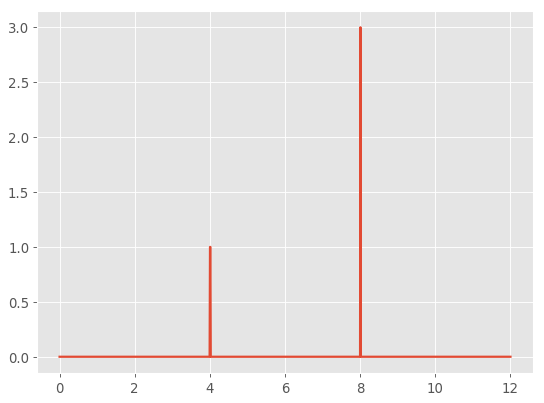

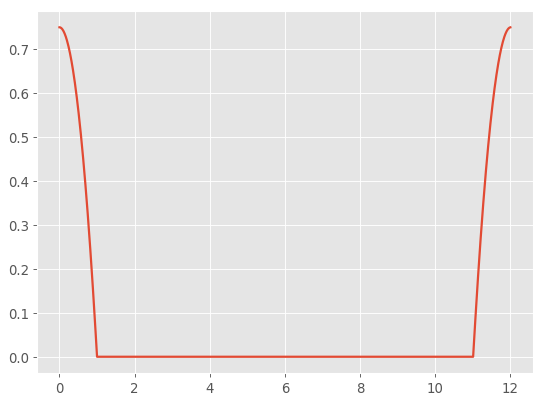

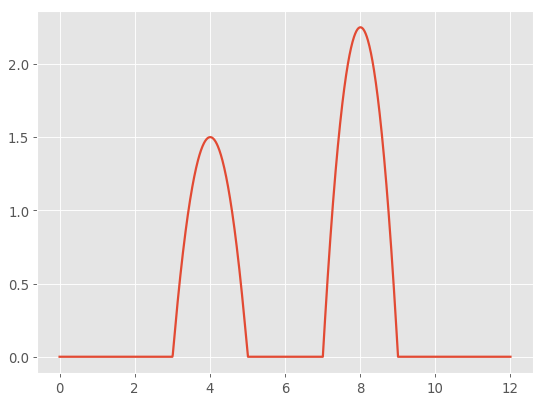

0.9924805405078294
4.999932098907209


In [8]:
dists = np.zeros(1200)
dists[400] = 1
dists[401] = 1
dists[800] = 3

bins = np.linspace(0,12,1200)

plt.plot(bins, dists)
plt.show()

sing_kernel = mk_kernel(width=1, x=bins)

plt.plot(bins, sing_kernel)
plt.show()

new_density = conv_kernel(sing_kernel, dists)

plt.plot(bins, new_density)
plt.show()

print(np.trapz(sing_kernel, bins))
print(np.trapz(new_density, bins))

In [9]:
df = pd.read_excel("info/Sigma3-GBs-Data-updated.xlsx")
pids = list(df[df.columns[0]])
df.shape
gb = np.array(df[df.columns[1]])
mb = np.array(df[df.columns[2]])

In [10]:
df.head(3)

,PIDs,GB Energy,Mobility (1000K - 0.010 eV/atom DF) Units (m s^-1 Gpa^-1)
0,3,0.064,0.000000
1,4,0.879,0.000000
2,5,1.005,2689.427271


## Properties

## Grain Boundary Energy

0.064
1.005


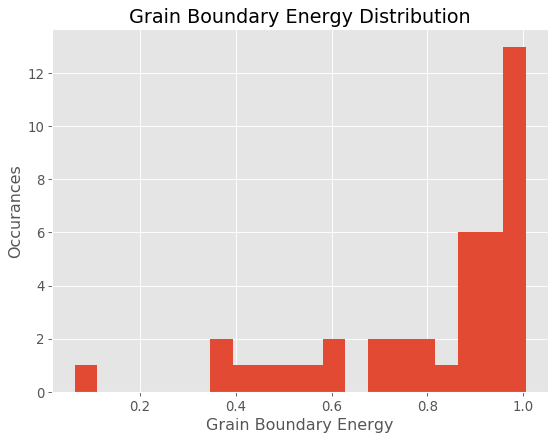

In [13]:
print(np.min(gb))
print(np.max(gb))
plt.hist(gb, 20)
plt.title("Grain Boundary Energy Distribution")
plt.xlabel("Grain Boundary Energy")
plt.ylabel("Occurances")
plt.show()

## Mobility

min: 0.0
max: 2922.306089


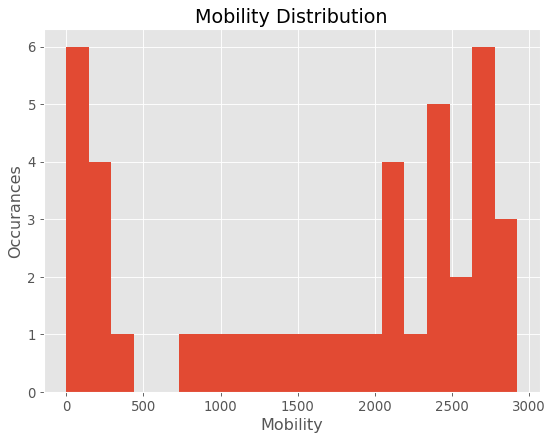

In [14]:
print("min:", np.min(mb))
print("max:", np.max(mb))
plt.hist(mb, 20)
plt.title("Mobility Distribution")
plt.xlabel("Mobility")
plt.ylabel("Occurances")
plt.show()

Pearson Correlation between GB and Mobility

In [15]:
np.corrcoef(gb, mb)[0,1]

0.4778011955290003

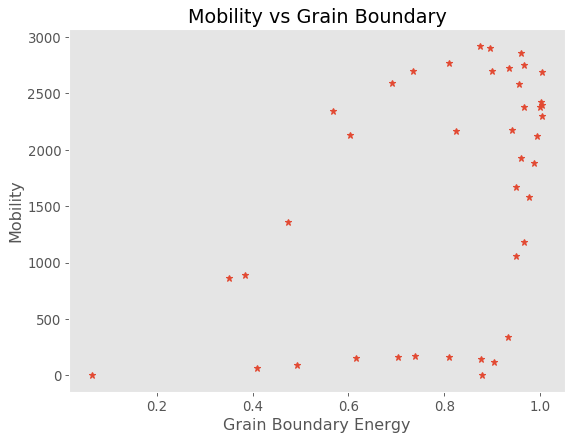

In [17]:
plt.plot(gb, mb, "*")
plt.ylabel("Mobility")
plt.xlabel("Grain Boundary Energy")
plt.title("Mobility vs Grain Boundary")
plt.grid(False)
plt.show()

## RDF Computation

In [48]:
# %%time
# smooth_pdf_list = []
# pdf_list = []
# for pid in pids:
#     try:
#         fname = "data/ni.%d.f.data" % pid
#         print(fname)
#         coords, box_dim = get_coords(fname)
#         cell = [(box_dim[i,1] - box_dim[i,0]) for i in range(3)] 
#         pbc = [1, 1, 1]
#         a = Atoms(positions=coords, cell=cell, pbc=pbc)

#         i, j, d, D = neighbor_list('ijdD', a, cutoff=6)

#         idxs = (gb_coords(a)[:,3]).astype(int)
#         dlist = []
#         for idx in idxs:
#             dlist.append(d[np.where(i == idx)[0]])
#         dlist = np.concatenate(dlist, axis=0)
#         bins = np.linspace(0.0, 7.0, 201)
#         N = len(idxs)
#         h, bin_edges = np.histogram(dlist, bins)
#         pdf = h / N
#         bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2
#         sing_kernel = mk_kernel(width=0.1, x=bin_centers)
#         new_pdf = conv_kernel(sing_kernel, pdf)
#         pdf_list.append(pdf)
#         smooth_pdf_list.append(new_pdf)
#     except Exception as err:
#         print(fname, err)
#         continue

In [290]:
# lst = []
# for ls in pdf_list:
#     lst.append(ls[:,None])
# lst = np.concatenate(lst, axis=1)
# lst = lst.T
# np.save("rdf_spiky_7_200_.npy", lst)
# lst = []
# for ls in smooth_pdf_list:
#     lst.append(ls[:,None])
# lst = np.concatenate(lst, axis=1)
# lst = lst.T
# np.save("rdf_smooth_7_200_.npy", lst)

In [13]:
# lst.shape

## Linkage

In [11]:
df = pd.read_excel("info/Sigma3-GBs-Data-updated.xlsx")
pids = list(df[df.columns[0]])
# df = df[df.PIDs != 84]
df.shape
gb = np.array(df[df.columns[1]])
mb = np.array(df[df.columns[2]])

In [14]:
# lst = np.load("rdf_long.npy")
# lst = np.load("rdf_smooth_7_200.npy")
# lst = np.load("rdf_spiky_7_200.npy")
lst = np.load("rdf_spiky_7_200_.npy")

In [17]:
bins = np.linspace(0, 7.0, lst.shape[1]+1)
bin_centers = bins[:-1] + (bins[1:] - bins[:-1])/2
vols = 4 * np.pi / 3 * (bins[1:]**3 - bins[:-1]**3)

## $X(r) = \dfrac{n\left(r\right)}{\dfrac{4}{3}\pi(r_1^3 - r_0^3)n_0}$

In [30]:
lst = lst / vols
bin_centers = bins[:-1] + (bins[1:] - bins[:-1])/2
sing_kernel = mk_kernel(width=0.15, x=bin_centers)
lst = conv_kernel(sing_kernel, lst)

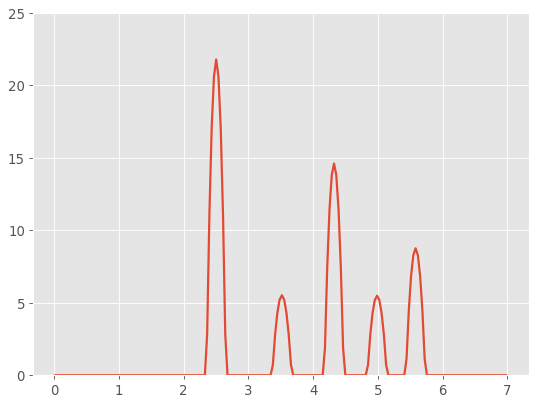

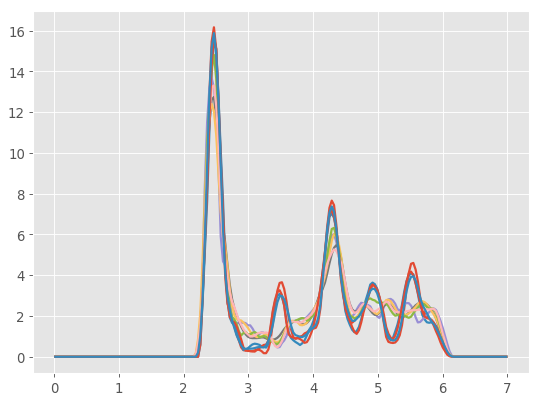

In [31]:
plt.plot(bin_centers, lst[0,:])
plt.ylim([0.0, 25.0])
plt.show()
plt.plot(bin_centers, lst[1,:])
plt.plot(bin_centers, lst[5,:])
plt.plot(bin_centers, lst[10,:])
plt.plot(bin_centers, lst[15,:])
plt.plot(bin_centers, lst[20,:])
plt.plot(bin_centers, lst[25,:])
plt.plot(bin_centers, lst[30,:])
plt.plot(bin_centers, lst[35,:])
plt.plot(bin_centers, lst[40,:])
plt.show()

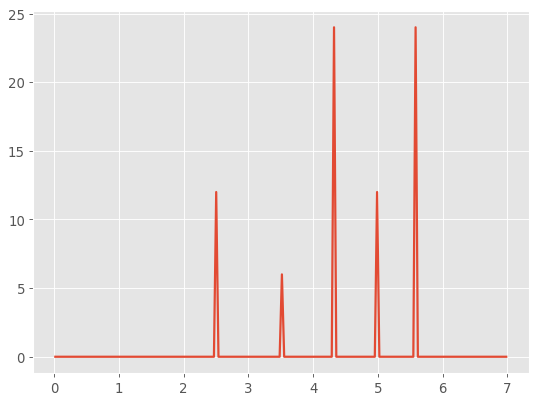

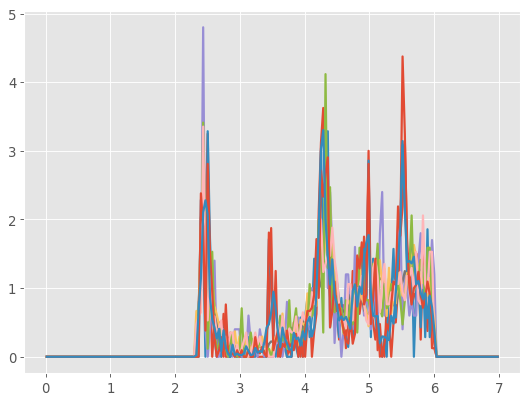

In [19]:
plt.plot(bin_centers, lst[0,:])
plt.show()
plt.plot(bin_centers, lst[1,:])
plt.plot(bin_centers, lst[5,:])
plt.plot(bin_centers, lst[10,:])
plt.plot(bin_centers, lst[15,:])
plt.plot(bin_centers, lst[20,:])
plt.plot(bin_centers, lst[25,:])
plt.plot(bin_centers, lst[30,:])
plt.plot(bin_centers, lst[35,:])
plt.plot(bin_centers, lst[40,:])
plt.show()

In [32]:
components = 40
pca = PCA(n_components=components)

In [33]:
scores = pca.fit_transform(lst)

In [34]:
ex_var = pca.explained_variance_ratio_
print(ex_var)

[8.42650888e-01 7.24613935e-02 3.21742085e-02 1.58215781e-02
 1.41898960e-02 5.85612755e-03 4.51067784e-03 3.43170936e-03
 2.28730972e-03 1.71372619e-03 1.21322741e-03 6.30256114e-04
 5.36613841e-04 4.52950789e-04 3.58746960e-04 2.96822752e-04
 2.37591323e-04 2.12943024e-04 1.77799583e-04 1.22652558e-04
 1.15490524e-04 8.86666732e-05 8.58643772e-05 7.07199294e-05
 6.24560830e-05 5.17763009e-05 4.16163033e-05 3.14176621e-05
 2.38910399e-05 2.06375390e-05 1.56273343e-05 1.28955584e-05
 1.17341962e-05 7.51169023e-06 6.33078222e-06 5.80007631e-06
 3.96479885e-06 3.11698543e-06 2.24972119e-06 1.11329440e-06]


In [35]:
np.cumsum(ex_var)

array([0.84265089, 0.91511228, 0.94728649, 0.96310807, 0.97729796,
       0.98315409, 0.98766477, 0.99109648, 0.99338379, 0.99509751,
       0.99631074, 0.996941  , 0.99747761, 0.99793056, 0.99828931,
       0.99858613, 0.99882372, 0.99903667, 0.99921447, 0.99933712,
       0.99945261, 0.99954128, 0.99962714, 0.99969786, 0.99976032,
       0.99981209, 0.99985371, 0.99988513, 0.99990902, 0.99992966,
       0.99994528, 0.99995818, 0.99996991, 0.99997742, 0.99998376,
       0.99998956, 0.99999352, 0.99999664, 0.99999889, 1.        ])

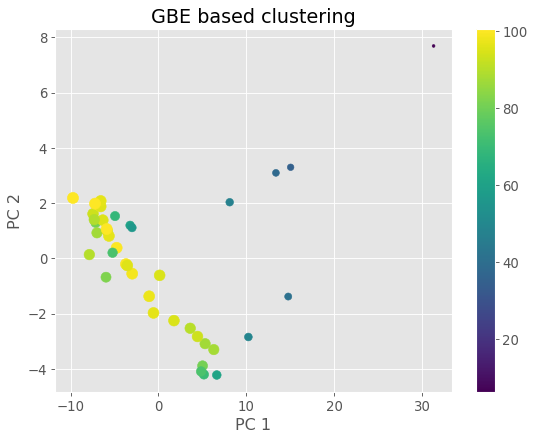

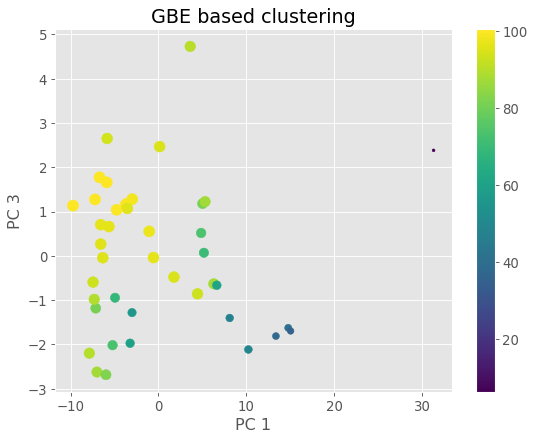

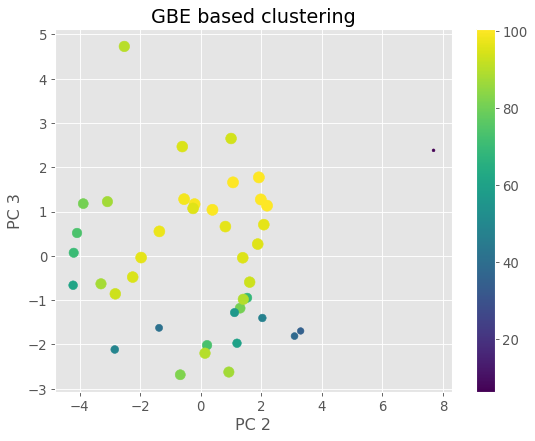

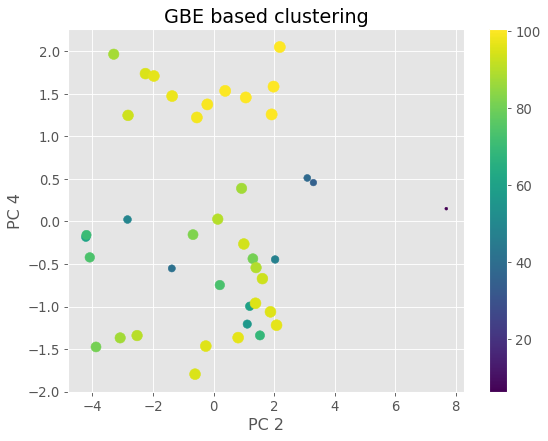

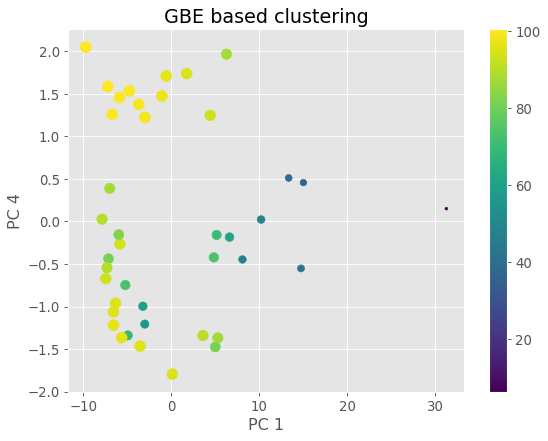

In [36]:
plt.scatter(scores[:,0], scores[:,1], c=gb*100, s = gb*100)
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("GBE based clustering")
plt.show()

plt.scatter(scores[:,0], scores[:,2], c=gb*100, s = gb*100)
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.title("GBE based clustering")
plt.show()

plt.scatter(scores[:,1], scores[:,2], c=gb*100, s = gb*100)
plt.colorbar()
plt.xlabel("PC 2")
plt.ylabel("PC 3")
plt.title("GBE based clustering")
plt.show()

plt.scatter(scores[:,1], scores[:,3], c=gb*100, s = gb*100)
plt.colorbar()
plt.xlabel("PC 2")
plt.ylabel("PC 4")
plt.title("GBE based clustering")
plt.show()

plt.scatter(scores[:,0], scores[:,3], c=gb*100, s = gb*100)
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 4")
plt.title("GBE based clustering")
plt.show()

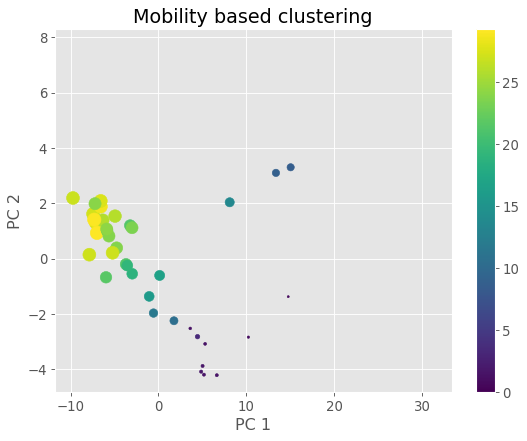

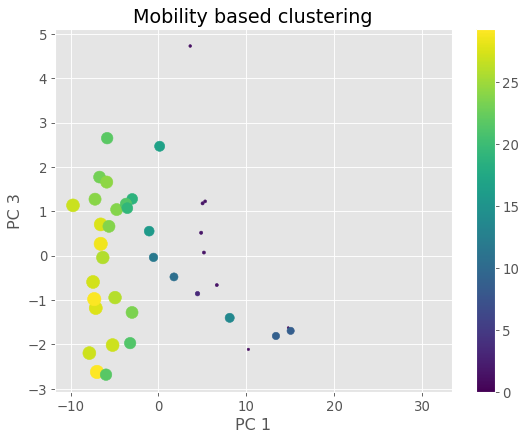

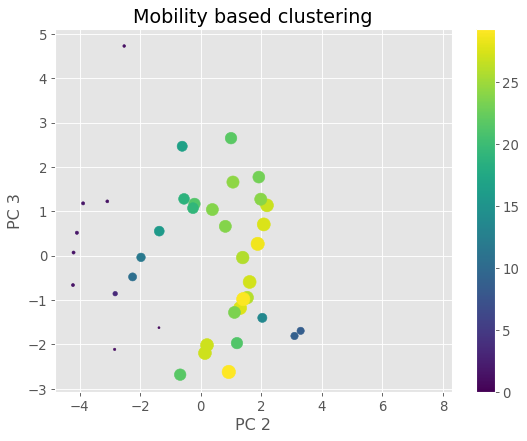

In [37]:
plt.scatter(scores[:,0], scores[:,1], c=mb/ 100, s = mb/20)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Mobility based clustering")
plt.colorbar()
plt.show()

plt.scatter(scores[:,0], scores[:,2], c=mb/ 100, s = mb/20)
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.title("Mobility based clustering")
plt.colorbar()
plt.show()

plt.scatter(scores[:,1], scores[:,2], c=mb/ 100, s = mb/20)
plt.xlabel("PC 2")
plt.ylabel("PC 3")
plt.title("Mobility based clustering")
plt.colorbar()
plt.show()

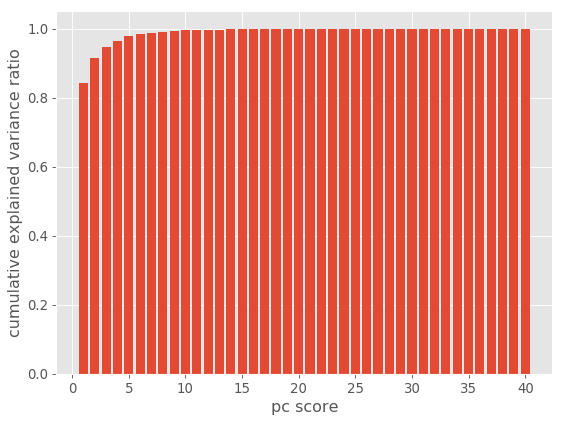

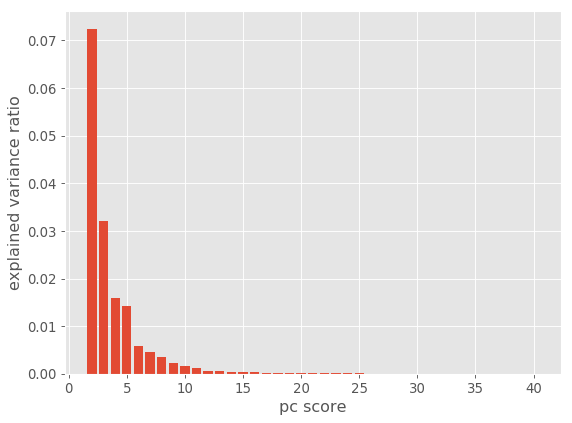

In [38]:
plt.bar(np.arange(1, components+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("pc score")
plt.ylabel("cumulative explained variance ratio")
plt.show()

plt.bar(np.arange(2, components+1), pca.explained_variance_ratio_[1:])
plt.xlabel("pc score")
plt.ylabel("explained variance ratio")
plt.show()

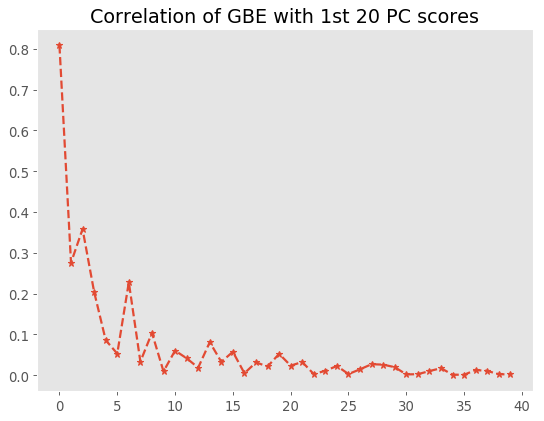

In [39]:
corrs_gb = []
for i in range(components):
    corrs_gb.append(np.corrcoef(scores[:,i], gb)[0,1])
plt.plot(np.abs(corrs_gb), "--*")
plt.grid(False)
plt.title("Correlation of GBE with 1st 20 PC scores")
plt.show()

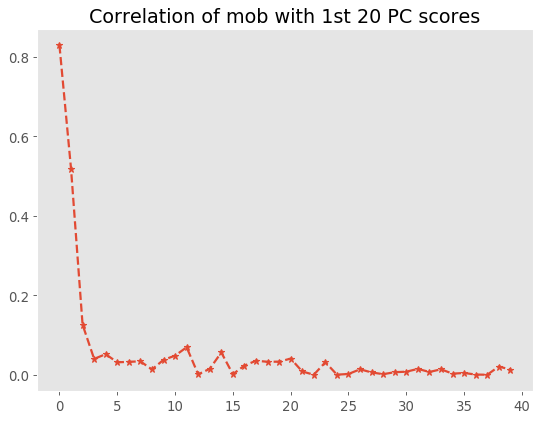

In [40]:
corrs_mb = []
for i in range(components):
    corrs_mb.append(np.corrcoef(scores[:,i], mb)[0,1])
plt.plot(np.abs(corrs_mb), "--*")
plt.grid(False)
plt.title("Correlation of mob with 1st 20 PC scores")
plt.show()

In [41]:
poly = PolynomialFeatures(degree=3)

In [49]:
x1 = poly.fit_transform(scores)
print(x1.shape)

(41, 12341)


In [51]:
corrs_mb = []
for i in range(1, x1.shape[0]):
    corrs_mb.append(np.corrcoef(x1[:,i], mb)[0,1])

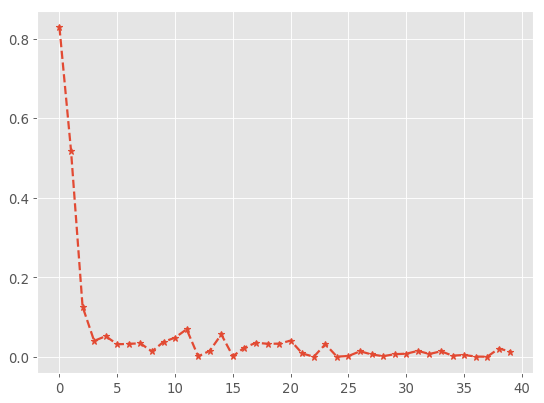

In [52]:
plt.plot(np.abs(corrs_mb), "--*")
plt.show()

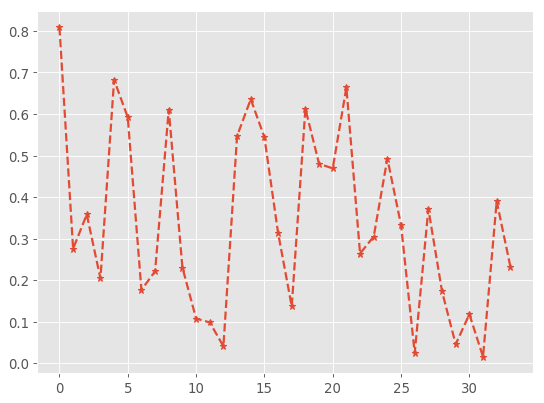

In [46]:
corrs_gb = []
for i in range(1, 35):
    corrs_gb.append(np.corrcoef(x1[:,i], gb)[0,1])
plt.plot(np.abs(corrs_gb), "--*")
plt.show()

In [47]:
idx_gb = (np.where(np.abs(corrs_gb) > 0.5)[0] + 1)
idx_gb = np.concatenate([np.array([0]), idx_gb])
idx_mb = (np.where(np.abs(corrs_mb) > 0.5)[0] + 1)
idx_mb = np.concatenate([np.array([0]), idx_mb])
x_mb = x1[:,idx_mb]
print(idx_mb)
print(x_mb.shape)
x_gb = x1[:,idx_gb]
print(idx_gb)
print(x_gb.shape)

[ 0  1  2  9 22 24 30]
(41, 7)
[ 0  1  5  6  9 14 15 16 19 22]
(41, 10)


## Mobility as function of pc scores

[ 67.62622754 167.05513269 186.86205715 149.2955163   99.53666234
  91.84201645]
127.03626874429915
7.791344779524924


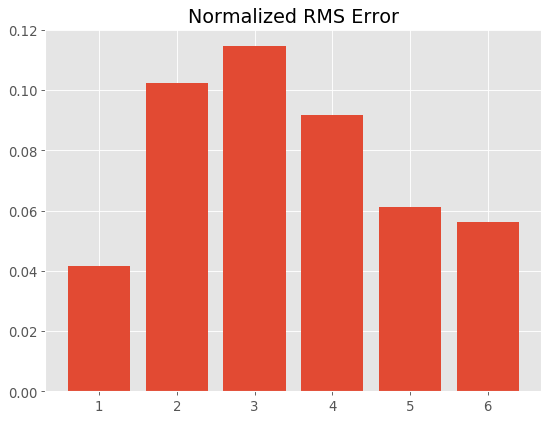

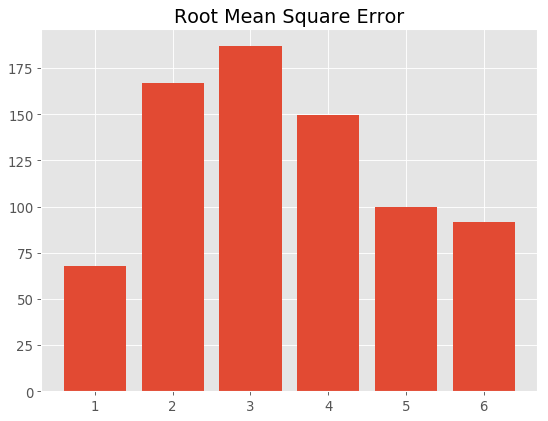

114.21457196137237
0.07004968878518376


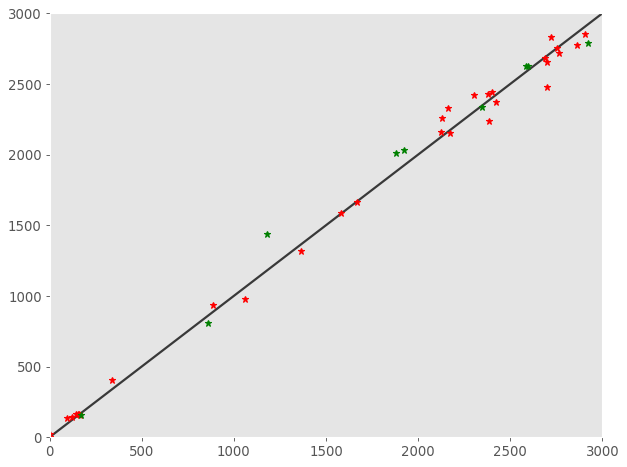

In [119]:
x = scores.copy()[:,:20]
y = mb
x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)

# model = LinearRegression()
# model = BayesianRidge()
model = Ridge(alpha=0.4)
# model = GradientBoostingRegressor(n_estimators=100, max_depth=2, random_state=0)
# model = RandomForestRegressor(n_estimators=100, bootstrap=True)
n_fold = 6
score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
print(np.sqrt(-1*score))
print(np.mean(np.sqrt(-1*score)))
print(np.mean(np.sqrt(-1*score)) / np.mean(y) * 100)

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1) / np.mean(y))
plt.title("Normalized RMS Error")
plt.show()

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1))
plt.title("Root Mean Square Error")
plt.show()


model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_ = model.predict(x_train)

print(np.sqrt(mean_squared_error(y_pred, y_test)))
print(np.sqrt(mean_squared_error(y_pred, y_test)) / np.mean(y))

plt.plot(y_train, y_pred_, "r*")
plt.plot(y_test, y_pred, "g*")
plt.xlim([0.0, 3000.0])
plt.ylim([0.0, 3000.0])
lims = [0.0, 3000.0]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.tight_layout()
plt.grid(False)
plt.show()

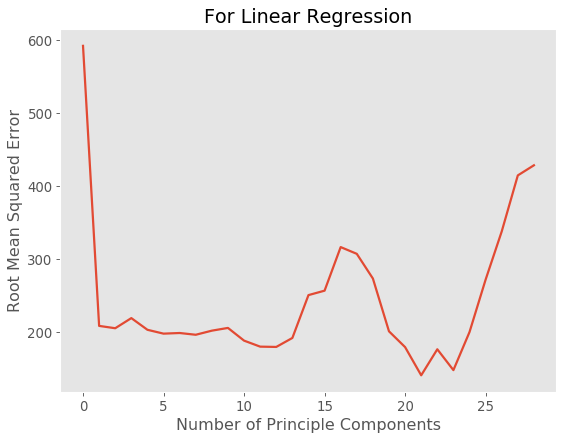

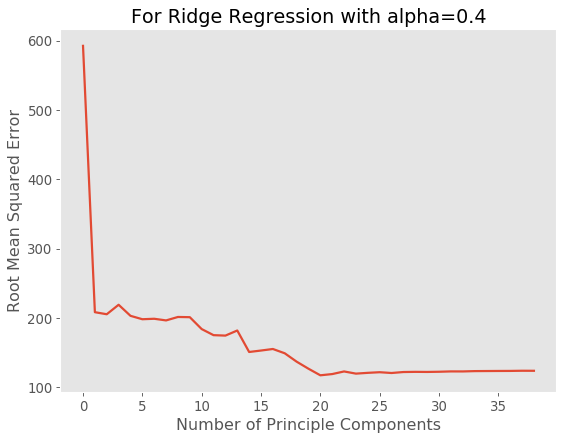

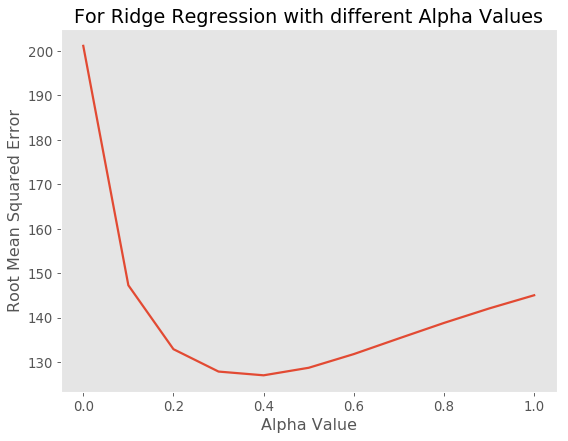

In [117]:
errs = []
for i in range(1,30):
    x = scores.copy()[:,:i]
    y = mb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=0.0)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Number of Principle Components")
plt.title("For Linear Regression")
plt.grid(False)
plt.show()

errs = []
for i in range(1,40):
    x = scores.copy()[:,:i]
    y = mb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=0.4)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Number of Principle Components")
plt.title("For Ridge Regression with alpha=0.4")
plt.grid(False)
plt.show()

errs = []
for i in np.arange(0.0,1.01, 0.1):
    x = scores.copy()[:,:20]
    y = mb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=i)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(np.arange(0.0,1.01, 0.1), errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Alpha Value")
plt.title("For Ridge Regression with different Alpha Values")
plt.grid(False)
plt.show()

In [ ]:
errs = []
for i in np.arange(0.0,20):
    x = scores.copy()[:,:i]
    y = mb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=0.0)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Number of Principle Components")
plt.show()

75.96375524785701
0.04658982932463213


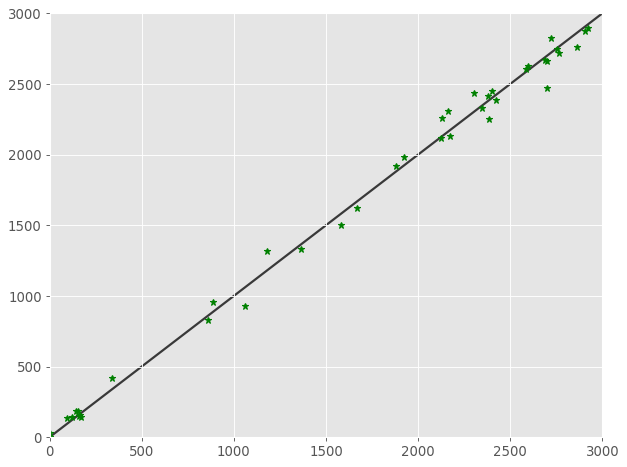

In [121]:
x = scores[:,:20]
y = mb
model = Ridge(alpha=0.4)
model.fit(x, y)
y_pred = model.predict(x)

print(np.sqrt(mean_squared_error(y_pred, y)))
print(np.sqrt(mean_squared_error(y_pred, y)) / np.mean(y))

plt.plot(y, y_pred, "g*")
plt.xlim([0.0, 3000.0])
plt.ylim([0.0, 3000.0])
lims = [0.0, 3000.0]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()

30
[117.05118432 161.50519613 225.74769449 186.69483567 117.48670295
  91.68997757]
150.02926518769368
0.06878602977198131


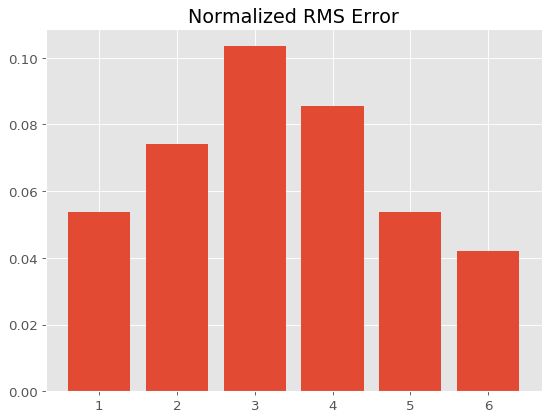

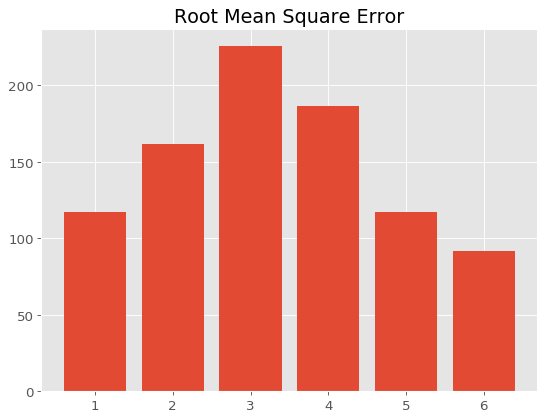

68.86131761191612
0.03157181792142548


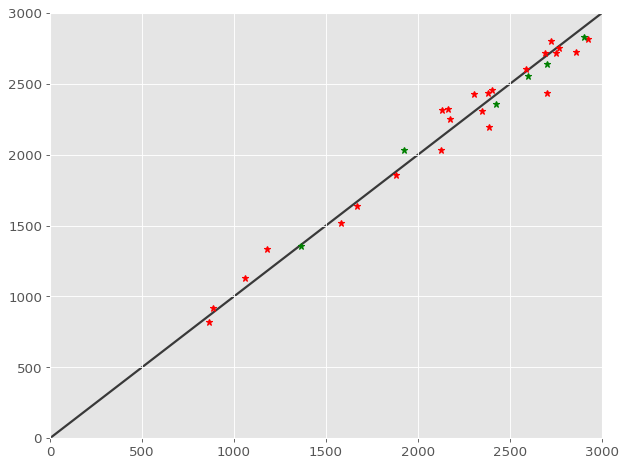

In [32]:
idx = np.where(mb > 500)[0]
print(len(idx))
x = scores[idx]
y = mb[idx]

x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)

# model = LinearRegression()
model = Ridge(alpha=2.0)
# model = GradientBoostingRegressor(n_estimators=100, max_depth=2, random_state=0)
# model = RandomForestRegressor(n_estimators=100, bootstrap=True)
n_fold = 6
score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
print(np.sqrt(-1*score))
print(np.mean(np.sqrt(-1*score)))
print(np.mean(np.sqrt(-1*score)) / np.mean(y))

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1) / np.mean(y))
plt.title("Normalized RMS Error")
plt.show()

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1))
plt.title("Root Mean Square Error")
plt.show()


model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_ = model.predict(x_train)

print(np.sqrt(mean_squared_error(y_pred, y_test)))
print(np.sqrt(mean_squared_error(y_pred, y_test)) / np.mean(y))

plt.plot(y_train, y_pred_, "r*")
plt.plot(y_test, y_pred, "g*")
plt.xlim([0.0, 3000.0])
plt.ylim([0.0, 3000.0])
lims = [0.0, 3000.0]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.tight_layout()
plt.show()

## Grain Boundary Energy as function of first 10 pc scores

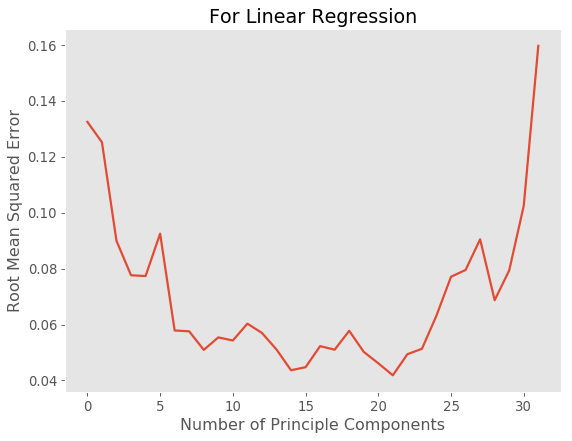

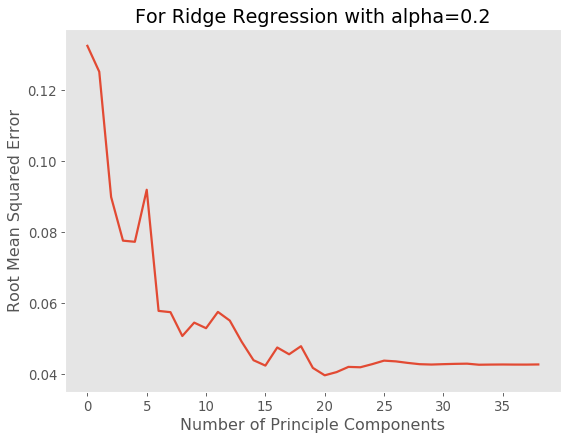

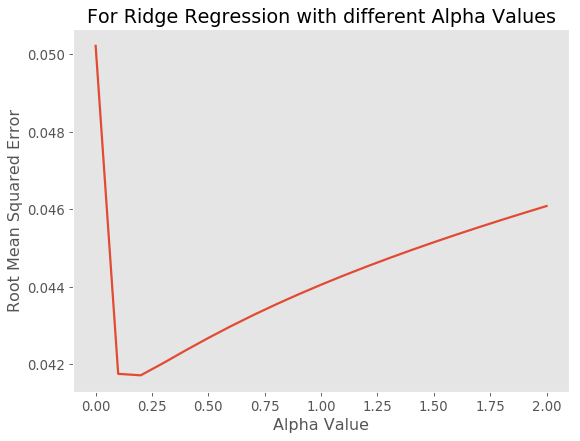

In [133]:
errs = []
for i in range(1,33):
    x = scores.copy()[:,:i]
    y = gb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=0.0)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Number of Principle Components")
plt.title("For Linear Regression")
plt.grid(False)
plt.show()

errs = []
for i in range(1,40):
    x = scores.copy()[:,:i]
    y = gb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=0.2)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Number of Principle Components")
plt.title("For Ridge Regression with alpha=0.2")
plt.grid(False)
plt.show()

errs = []
for i in np.arange(0.0,2.01, 0.1):
    x = scores.copy()[:,:20]
    y = gb
    x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=0)
    model = Ridge(alpha=i)
    n_fold = 6
    score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
    errs.append(np.mean(np.sqrt(-1*score)))

plt.plot(np.arange(0.0,2.01, 0.1), errs)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Alpha Value")
plt.title("For Ridge Regression with different Alpha Values")
plt.grid(False)
plt.show()

[0.06923886 0.02188935 0.05930958 0.05891675 0.01155195 0.03524958]
0.042692678416469676
0.05294295006579325


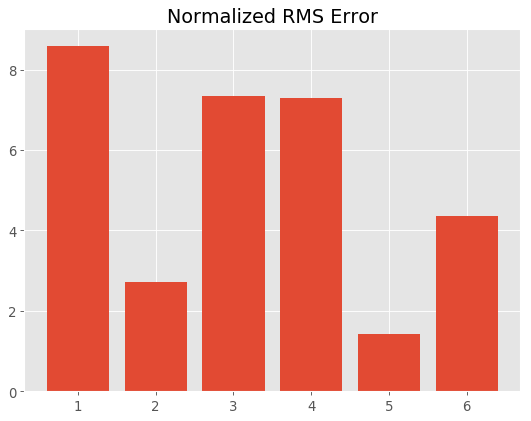

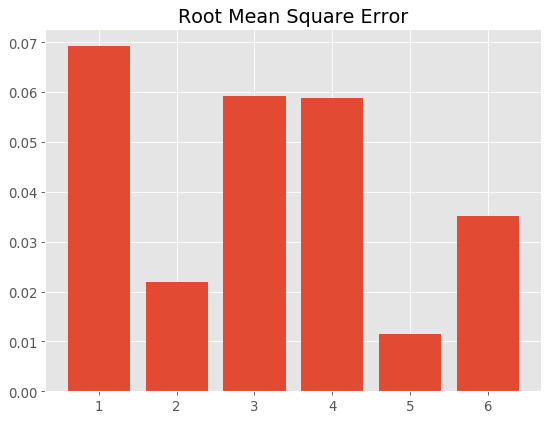

0.027748128317278766
0.03441029765314951


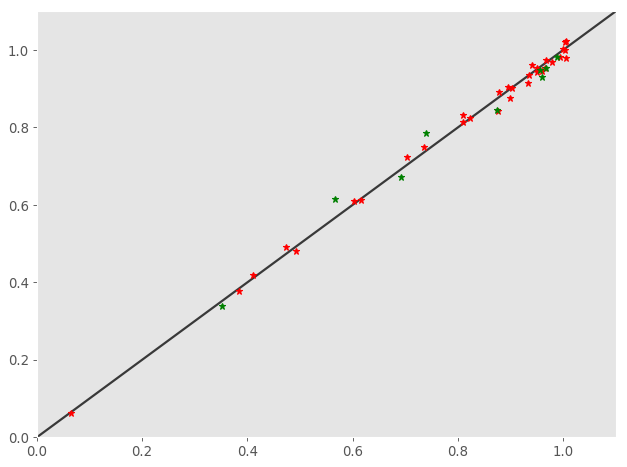

In [135]:
x = scores.copy()
y = gb
x_train,x_test,y_train,y_test = train_test_split(x[:,:20], y,test_size=0.2,random_state=0)

model = Ridge(alpha=0.2)
n_fold = 6
score = cross_val_score(estimator=model, X=x, y=y, cv=n_fold, scoring='neg_mean_squared_error')
print(np.sqrt(score * -1))
print(np.mean(np.sqrt(score * -1)))
print(np.mean(np.sqrt(score * -1))/np.mean(y))

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1) / np.mean(y) *100)
plt.title("Normalized RMS Error")
plt.show()

plt.bar(np.arange(1,n_fold+1), np.sqrt(score * -1))
plt.title("Root Mean Square Error")
plt.show()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_ = model.predict(x_train)

print(np.sqrt(mean_squared_error(y_pred, y_test)))
print(np.sqrt(mean_squared_error(y_pred, y_test)) / np.mean(y))

plt.plot(y_train, y_pred_, "r*")
plt.plot(y_test, y_pred, "g*")
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
lims = [0.0, 1.1]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.tight_layout()
plt.grid(False)
plt.show()

5.742511858366153
136.01590356224006
0.08342080656391929
135.8946267495853


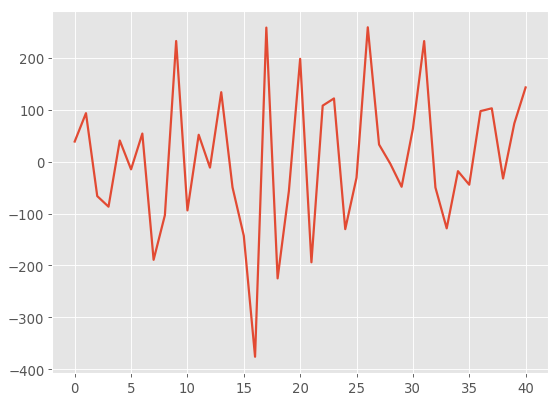

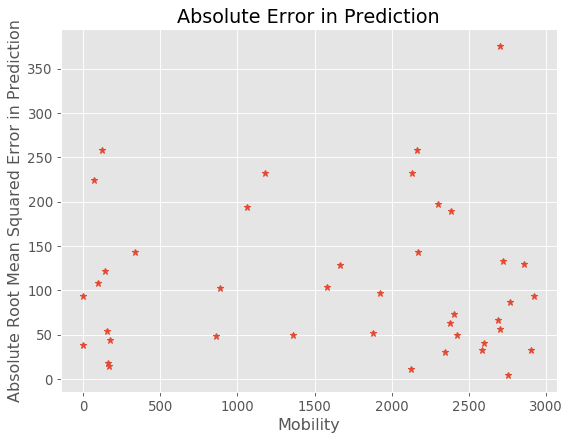

In [154]:
# model = LinearRegression()
errs = []
yy = []
model = Ridge(alpha=0.4)
for it in range(scores.shape[0]):
    x_train = np.concatenate([scores[0:it,:20], scores[it+1:,:20]], axis=0)
    y_train = np.concatenate([mb[0:it], mb[it+1:]], axis=0)
    x_test = scores[it,:20]
    y_test = mb[it]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test[None])
    yy.append(y_test)
    errs.append(y_pred- y_test)

print(np.mean(errs))
print(np.sqrt(np.mean(np.asarray(errs)**2)))
print(np.sqrt(np.mean(np.asarray(errs)**2)) / np.mean(yy))
print(np.std(errs))
plt.plot(errs)
plt.show()

plt.plot(yy, np.fabs(errs), "*")
plt.xlabel("Mobility")
plt.ylabel("Absolute Root Mean Squared Error in Prediction")
plt.title("Absolute Error in Prediction")
plt.show()

In [155]:
idxs = np.where(np.asarray(np.fabs(errs)) > 350)[0]

for idx in idxs:
    print(pids[idx])

89


0.031054466041211915
0.04329537288168823
0.05369034807783005
0.04318899536236728


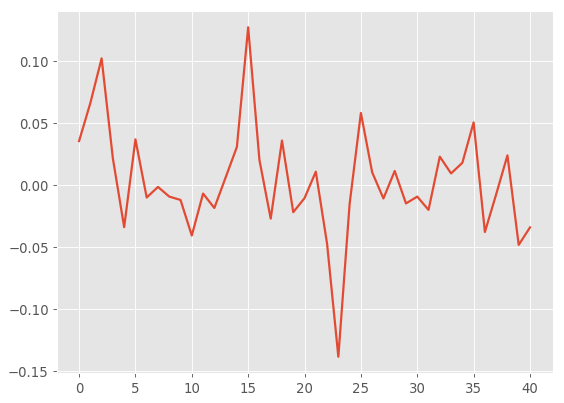

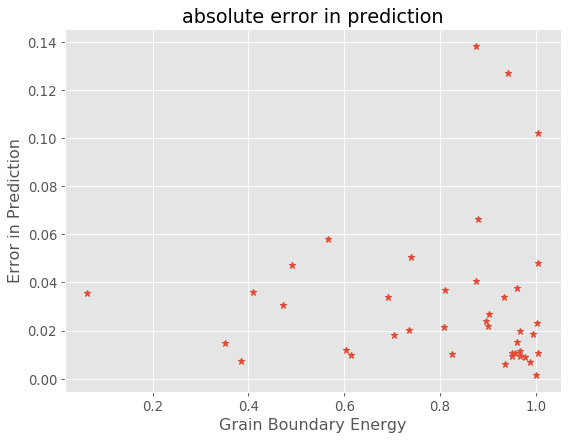

In [156]:
# model = LinearRegression()
errs = []
yy = []
model = Ridge(alpha=0.2)
for it in range(scores.shape[0]):
    x_train = np.concatenate([scores[0:it,:20], scores[it+1:,:20]], axis=0)
    y_train = np.concatenate([gb[0:it], gb[it+1:]], axis=0)
    x_test = scores[it,:20]
    y_test = gb[it]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test[None])
    yy.append(y_test)
    errs.append(y_pred- y_test)

print(np.mean(np.fabs(errs)))
print(np.sqrt(np.mean(np.asarray(errs)**2)))
print(np.sqrt(np.mean(np.asarray(errs)**2)) / np.mean(yy))
print(np.std(errs))

plt.plot(errs)
plt.show()

plt.plot(yy, np.fabs(errs), "*")
plt.title("absolute error in prediction")
plt.xlabel("Grain Boundary Energy")
plt.ylabel("Error in Prediction")
plt.show()

In [159]:
np.where(np.asarray(np.fabs(errs)) > 0.135)[0]

array([23])

In [160]:
print(pids[2])
print(pids[15])
print(pids[23])

5
84
163


## Demosntration of Approach

In [40]:
pid = 84
fname = "data/ni.%d.f.data" % pid
print(fname)
coords, box_dim = get_coords(fname)

data/ni.84.f.data


In [41]:
%%time
coords, box_dim = get_coords(fname)
cell = [(box_dim[i,1] - box_dim[i,0]) for i in range(3)] 
pbc = [1, 1, 1]
a = Atoms(positions=coords, cell=cell, pbc=pbc)

CPU times: user 60.4 ms, sys: 238 µs, total: 60.6 ms
Wall time: 59.6 ms


In [42]:
%%time
i, j, d, D = neighbor_list('ijdD', a, cutoff=6)

CPU times: user 4.18 s, sys: 1.72 s, total: 5.9 s
Wall time: 3.82 s


In [43]:
bins = np.linspace(1.0, 7.0, 201)
N = len(a)
h, bin_edges = np.histogram(d, bins)
pdf = h / N
bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2
sing_kernel = mk_kernel(width=0.10, x=bin_centers)
new_pdf = conv_kernel(sing_kernel, pdf)

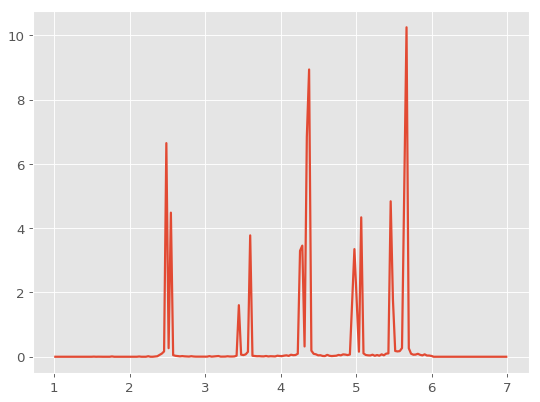

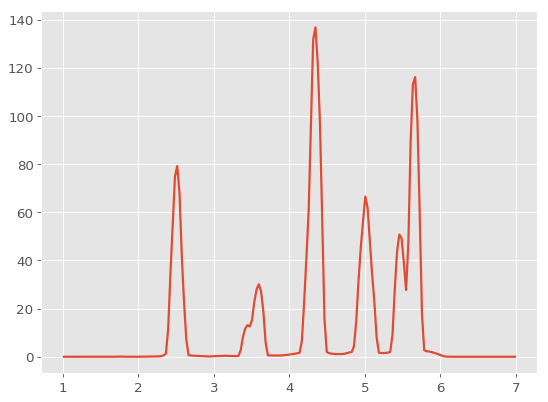

In [44]:
plt.plot(bin_centers, pdf)
plt.show()

plt.plot(bin_centers, new_pdf)
plt.show()

# Restricted Common Neighbor analysis on a list of atoms.

Sets the tags of the atoms according to their local crystal
structure.  FCC is class 0, HCP is class 1 and everything else is
class 2

In [45]:
idxs = (gb_coords(a)[:,3]).astype(int)

In [46]:
len(idxs)

403

In [47]:
dlist = []
for idx in idxs:
    dlist.append(d[np.where(i == idx)[0]])

In [48]:
dlist = np.concatenate(dlist, axis=0)

In [49]:
bins = np.linspace(0.0, 7.0, 201)
N = len(idxs)
h, bin_edges = np.histogram(dlist, bins)
pdf = h / N
bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2
sing_kernel = mk_kernel(width=0.10, x=bin_centers)
new_pdf = conv_kernel(sing_kernel, pdf)

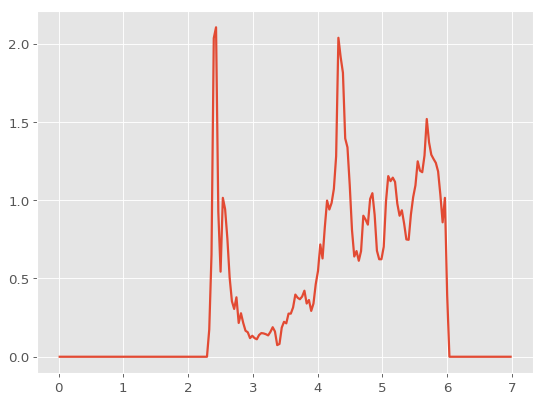

In [50]:
plt.plot(bin_centers, pdf)
plt.show()

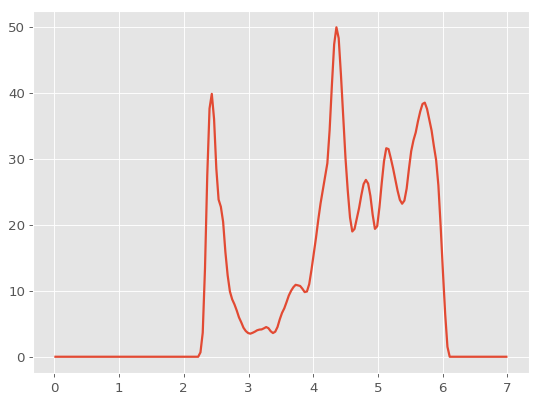

In [51]:
plt.plot(bin_centers, new_pdf)
plt.show()